In [22]:
from pathlib import Path

# Get the current notebook's directory
CURRENT_NOTEBOOK_DIR = Path().resolve()

# Assume project root is one level up from notebooks/
BASE_DIR = CURRENT_NOTEBOOK_DIR.parent.parent

# Define path to the data file
RAW_DATA_PATH = BASE_DIR / "Data_Gathering" / "City_Data" / "Gurgaon" / "Cleaned_Data"

# # Load the data
# import pandas as pd
# df = pd.read_csv(RAW_DATA_PATH)

In [23]:
import numpy as np
import pandas as pd
import re

In [24]:
df_cl = pd.read_csv(RAW_DATA_PATH/"gurgaon_properties_cleaned.csv")
df_cl

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,flat,signature global park 4,sector 36,0.82,7585.0,1081.0,Super Built up area 1081(100.43 sq.m.)Carpet a...,3,2,2,not available,2.0,NaN,0 to 1 Year Old,"['Sector 55-56 Metro Station', 'The Leaf Mall ...",NaN,"['Lift(s)', 'Park']"
1,flat,smart world gems,sector 89,0.95,8600.0,1105.0,Carpet area: 1103 (102.47 sq.m.),2,2,2,"study room,servant room",4.0,NaN,Within 6 months,"['Sant Soordas Sihi Metro Station', 'Airia Mal...",NaN,"['Power Back-up', 'Intercom Facility', 'Lift(s..."
2,flat,pyramid elite,sector 86,0.46,79.0,58228.0,Carpet area: 58141 (5401.48 sq.m.),2,2,1,not available,0.0,NaN,Under Construction,"['V3S Sapphire Ninety Mall', 'Sector 86 Road',...",[],"['Intercom Facility', 'Lift(s)', 'Park']"
3,flat,breez global hill view,sohna road,0.32,5470.0,585.0,Built Up area: 1000 (92.9 sq.m.)Carpet area: 5...,2,2,1,not available,17.0,NaN,0 to 1 Year Old,"['Huda City Centre', 'Omaxe City Centre', 'Nin...",[],"['Feng Shui / Vaastu Compliant', 'Security / F..."
4,flat,bestech park view sanskruti,sector 92,1.60,8020.0,1995.0,Super Built up area 1995(185.34 sq.m.)Built Up...,3,4,3+,"servant room,others",10.0,North-West,1 to 5 Year Old,"['Sapphire 93 Mall', 'Dwarka Expressway', 'NH-...","['3 Wardrobe', '6 Fan', '1 Exhaust Fan', '3 Ge...","['Centrally Air Conditioned', 'Water purifier'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3798,flat,pivotal devaan,sector 84,0.37,6346.0,583.0,Super Built up area 583(54.16 sq.m.)Carpet are...,2,2,1,not available,5.0,North-West,1 to 5 Year Old,"['Dwarka Expressway', 'RPS International Schoo...",[],"['Security / Fire Alarm', 'Power Back-up', 'Fe..."
3799,house,international city by sobha phase 1,sector 109,6.00,9634.0,6228.0,Plot area 692(578.6 sq.m.),5,5,3+,"pooja room,study room,servant room,store room",2.0,South-West,1 to 5 Year Old,"['Dwarka sector 21 metro station', 'Pacific D2...",NaN,"['Water purifier', 'Centrally Air Conditioned'..."
3800,flat,ansal api celebrity suites,sector 2,0.60,8163.0,735.0,Super Built up area 735(68.28 sq.m.),1,1,1,not available,5.0,North-East,5 to 10 Year Old,"['Palam Vihar Vyapar kendra', 'Palam triangle'...","['1 Wardrobe', '2 Fan', '1 Exhaust Fan', '1 Ge...","['Power Back-up', 'Intercom Facility', 'Lift(s..."
3801,house,independent,sector 43,15.50,28233.0,5490.0,Plot area 610(510.04 sq.m.),5,6,3,"pooja room,study room,servant room,store room",3.0,East,5 to 10 Year Old,"['Iffco chowk metro station', 'Huda city centr...",[],"['Private Garden / Terrace', 'Water purifier',..."


In [ ]:
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [25]:
int(df_cl.duplicated().sum())

122

In [26]:
df_cl.head(1)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,flat,signature global park 4,sector 36,0.82,7585.0,1081.0,Super Built up area 1081(100.43 sq.m.)Carpet a...,3,2,2,not available,2.0,NaN,0 to 1 Year Old,"['Sector 55-56 Metro Station', 'The Leaf Mall ...",NaN,"['Lift(s)', 'Park']"


## Action 1: areaWithType
The column has three different value which needs to be treated

##### Target: Create three column from this column

In [29]:
df_cl.sample(5)[['price','area','areaWithType']]

,price,area,areaWithType
1932,1.85,1919.0,Super Built up area 1815(168.62 sq.m.)
241,1.75,1128.0,Super Built up area 1852(172.06 sq.m.)Carpet a...
1077,0.90,1950.0,Super Built up area 1950(181.16 sq.m.)
1336,1.25,2108.0,Super Built up area 1720(159.79 sq.m.)
3011,1.65,2800.0,Carpet area: 2800 (260.13 sq.m.)


In [32]:
# This function extracts the Super Built up area
def get_super_built_up_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [33]:
# This function extracts the Built Up area or Carpet area
def get_area(text, area_type):
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [34]:
# This function checks if the area is provided in sq.m. and converts it to sqft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [37]:
# Extract Super Built up area and convert to sqft if needed
df_cl['super_built_up_area'] = df_cl['areaWithType'].apply(get_super_built_up_area)
df_cl['super_built_up_area'] = df_cl.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built Up area and convert to sqft if needed
df_cl['built_up_area'] = df_cl['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df_cl['built_up_area'] = df_cl.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract Carpet area and convert to sqft if needed
df_cl['carpet_area'] = df_cl['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df_cl['carpet_area'] = df_cl.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [39]:
df_cl[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2844,1.47,flat,1150.0,Carpet area: 1150 (106.84 sq.m.),NaN,NaN,1150.0
1630,4.78,flat,3090.0,Super Built up area 3090(287.07 sq.m.)Built Up...,3090.0,2500.0,2250.0
3420,1.38,flat,2535.0,Super Built up area 2535(235.51 sq.m.),2535.0,NaN,NaN
1742,1.01,flat,1750.0,Super Built up area 1750(162.58 sq.m.)Built Up...,1750.0,1475.0,1350.0
2672,1.79,flat,1591.0,Super Built up area 1789(166.2 sq.m.),1789.0,NaN,NaN


In [42]:
int(df_cl.duplicated().sum())

122

In [43]:

df_cl[~((df_cl['super_built_up_area'].isnull()) | (df_cl['built_up_area'].isnull()) | (df_cl['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].shape


(534, 7)

In [44]:
df_cl[df_cl['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].head(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
9,1.2,house,1186.0,Plot area 1185.51(110.14 sq.m.),NaN,NaN,NaN
10,4.5,house,1350.0,Plot area 150(125.42 sq.m.),NaN,NaN,NaN
15,1.2,house,846.0,Plot area 846(78.6 sq.m.)Built Up area: 846 sq...,NaN,846.0,NaN
19,5.5,house,1440.0,Plot area 160(133.78 sq.m.),NaN,NaN,NaN
25,9.0,house,3240.0,Plot area 360(301.01 sq.m.),NaN,NaN,NaN


In [45]:
df_cl.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2616
carpet_area            1859
dtype: int64

In [46]:
all_nan_df = df_cl[((df_cl['super_built_up_area'].isnull()) & (df_cl['built_up_area'].isnull()) & (df_cl['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

In [47]:

all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
9,1.2,house,1186.0,Plot area 1185.51(110.14 sq.m.),NaN,NaN,NaN
10,4.5,house,1350.0,Plot area 150(125.42 sq.m.),NaN,NaN,NaN
19,5.5,house,1440.0,Plot area 160(133.78 sq.m.),NaN,NaN,NaN
25,9.0,house,3240.0,Plot area 360(301.01 sq.m.),NaN,NaN,NaN
26,7.0,house,2475.0,Plot area 275(229.94 sq.m.),NaN,NaN,NaN


In [48]:
all_nan_index = df_cl[((df_cl['super_built_up_area'].isnull()) & (df_cl['built_up_area'].isnull()) & (df_cl['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].index

In [49]:
# Function to extract plot area from 'areaWithType' column
def extract_plot_area(area_with_type):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [50]:
all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

# Update the original dataframe
#gurgaon_properties.update(filtered_rows)

In [51]:
all_nan_df

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
9,1.20,house,1186.0,Plot area 1185.51(110.14 sq.m.),NaN,1185.51,NaN
10,4.50,house,1350.0,Plot area 150(125.42 sq.m.),NaN,150.00,NaN
19,5.50,house,1440.0,Plot area 160(133.78 sq.m.),NaN,160.00,NaN
25,9.00,house,3240.0,Plot area 360(301.01 sq.m.),NaN,360.00,NaN
26,7.00,house,2475.0,Plot area 275(229.94 sq.m.),NaN,275.00,NaN
...,...,...,...,...,...,...,...
3783,2.50,house,1900.0,Plot area 1900(176.52 sq.m.),NaN,1900.00,NaN
3791,6.44,house,2430.0,Plot area 270(225.75 sq.m.),NaN,270.00,NaN
3794,8.00,house,3042.0,Plot area 338(282.61 sq.m.),NaN,338.00,NaN
3799,6.00,house,6228.0,Plot area 692(578.6 sq.m.),NaN,692.00,NaN


In [55]:
def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    else:
        if round(row['area']/row['built_up_area']) == 9.0:
            return row['built_up_area'] * 9
        elif round(row['area']/row['built_up_area']) == 11.0:
            return row['built_up_area'] * 10.7
        else:
            return row['built_up_area']

In [56]:
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)

In [57]:
all_nan_df

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
9,1.20,house,1186.0,Plot area 1185.51(110.14 sq.m.),NaN,1185.51,NaN
10,4.50,house,1350.0,Plot area 150(125.42 sq.m.),NaN,1350.00,NaN
19,5.50,house,1440.0,Plot area 160(133.78 sq.m.),NaN,1440.00,NaN
25,9.00,house,3240.0,Plot area 360(301.01 sq.m.),NaN,3240.00,NaN
26,7.00,house,2475.0,Plot area 275(229.94 sq.m.),NaN,2475.00,NaN
...,...,...,...,...,...,...,...
3783,2.50,house,1900.0,Plot area 1900(176.52 sq.m.),NaN,1900.00,NaN
3791,6.44,house,2430.0,Plot area 270(225.75 sq.m.),NaN,2430.00,NaN
3794,8.00,house,3042.0,Plot area 338(282.61 sq.m.),NaN,3042.00,NaN
3799,6.00,house,6228.0,Plot area 692(578.6 sq.m.),NaN,6228.00,NaN


In [58]:
# update the original dataframe
df_cl.update(all_nan_df)

In [60]:
df_cl.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2070
carpet_area            1859
dtype: int64

In [62]:
df_cl.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area
0,flat,signature global park 4,sector 36,0.82,7585.0,1081.0,Super Built up area 1081(100.43 sq.m.)Carpet a...,3,2,2,not available,2.0,NaN,0 to 1 Year Old,"['Sector 55-56 Metro Station', 'The Leaf Mall ...",NaN,"['Lift(s)', 'Park']",1081.0,NaN,650.0
1,flat,smart world gems,sector 89,0.95,8600.0,1105.0,Carpet area: 1103 (102.47 sq.m.),2,2,2,"study room,servant room",4.0,NaN,Within 6 months,"['Sant Soordas Sihi Metro Station', 'Airia Mal...",NaN,"['Power Back-up', 'Intercom Facility', 'Lift(s...",NaN,NaN,1103.0
2,flat,pyramid elite,sector 86,0.46,79.0,58228.0,Carpet area: 58141 (5401.48 sq.m.),2,2,1,not available,0.0,NaN,Under Construction,"['V3S Sapphire Ninety Mall', 'Sector 86 Road',...",[],"['Intercom Facility', 'Lift(s)', 'Park']",NaN,NaN,58141.0
3,flat,breez global hill view,sohna road,0.32,5470.0,585.0,Built Up area: 1000 (92.9 sq.m.)Carpet area: 5...,2,2,1,not available,17.0,NaN,0 to 1 Year Old,"['Huda City Centre', 'Omaxe City Centre', 'Nin...",[],"['Feng Shui / Vaastu Compliant', 'Security / F...",NaN,1000.0,585.0
4,flat,bestech park view sanskruti,sector 92,1.60,8020.0,1995.0,Super Built up area 1995(185.34 sq.m.)Built Up...,3,4,3+,"servant room,others",10.0,North-West,1 to 5 Year Old,"['Sapphire 93 Mall', 'Dwarka Expressway', 'NH-...","['3 Wardrobe', '6 Fan', '1 Exhaust Fan', '3 Ge...","['Centrally Air Conditioned', 'Water purifier'...",1995.0,1615.0,1476.0


## Additional Room

In [64]:
df_cl['additionalRoom'].value_counts()

additionalRoom
not available                                    1587
servant room                                      705
study room                                        250
others                                            225
pooja room                                        165
                                                 ... 
study room,store room,pooja room                    1
servant room,store room,study room,pooja room       1
store room,servant room,pooja room                  1
servant room,study room,others                      1
store room,pooja room,servant room,study room       1
Name: count, Length: 65, dtype: int64

In [67]:
# additional room
# List of new columns to be created
new_cols = ['study room', 'servant room', 'store room', 'pooja room', 'others']

# Populate the new columns based on the "additionalRoom" column
for col in new_cols:
    df_cl[col] = df_cl['additionalRoom'].str.contains(col).astype(int)

In [69]:
df_cl.sample(5)[['additionalRoom','study room', 'servant room', 'store room', 'pooja room', 'others']]

,additionalRoom,study room,servant room,store room,pooja room,others
2693,not available,0,0,0,0,0
2601,"study room,pooja room",1,0,0,1,0
1841,not available,0,0,0,0,0
3763,not available,0,0,0,0,0
712,"study room,others",1,0,0,0,1


In [71]:
df_cl.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,...,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,signature global park 4,sector 36,0.82,7585.0,1081.0,Super Built up area 1081(100.43 sq.m.)Carpet a...,3,2,2,...,NaN,"['Lift(s)', 'Park']",1081.0,NaN,650.0,0,0,0,0,0
1,flat,smart world gems,sector 89,0.95,8600.0,1105.0,Carpet area: 1103 (102.47 sq.m.),2,2,2,...,NaN,"['Power Back-up', 'Intercom Facility', 'Lift(s...",NaN,NaN,1103.0,1,1,0,0,0
2,flat,pyramid elite,sector 86,0.46,79.0,58228.0,Carpet area: 58141 (5401.48 sq.m.),2,2,1,...,[],"['Intercom Facility', 'Lift(s)', 'Park']",NaN,NaN,58141.0,0,0,0,0,0
3,flat,breez global hill view,sohna road,0.32,5470.0,585.0,Built Up area: 1000 (92.9 sq.m.)Carpet area: 5...,2,2,1,...,[],"['Feng Shui / Vaastu Compliant', 'Security / F...",NaN,1000.0,585.0,0,0,0,0,0
4,flat,bestech park view sanskruti,sector 92,1.60,8020.0,1995.0,Super Built up area 1995(185.34 sq.m.)Built Up...,3,4,3+,...,"['3 Wardrobe', '6 Fan', '1 Exhaust Fan', '3 Ge...","['Centrally Air Conditioned', 'Water purifier'...",1995.0,1615.0,1476.0,0,1,0,0,1


## AgePossession

In [72]:
df_cl['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1676
5 to 10 Year Old       575
0 to 1 Year Old        530
undefined              332
10+ Year Old           310
Under Construction      90
Within 6 months         70
Within 3 months         26
Dec 2023                22
By 2023                 19
By 2024                 17
Dec 2024                16
Mar 2024                14
Oct 2024                 8
Jan 2024                 8
Dec 2025                 7
Aug 2023                 7
Jun 2024                 7
Nov 2023                 5
Oct 2023                 4
By 2025                  4
Aug 2024                 4
Jul 2024                 4
Sep 2023                 4
Feb 2024                 3
Jan 2025                 3
Nov 2024                 3
May 2024                 3
Jun 2027                 2
Jan 2026                 2
Jul 2027                 2
Aug 2025                 2
Jul 2025                 2
Oct 2025                 2
Dec 2026                 2
Apr 2026                 2
By 2027       

In [73]:
def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

In [74]:
df_cl['agePossession'] = df_cl['agePossession'].apply(categorize_age_possession)

In [75]:
df_cl['agePossession'].value_counts()

agePossession
Relatively New        1676
New Property           626
Moderately Old         575
Undefined              333
Old Property           310
Under Construction     283
Name: count, dtype: int64

In [77]:
df_cl.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,...,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,signature global park 4,sector 36,0.82,7585.0,1081.0,Super Built up area 1081(100.43 sq.m.)Carpet a...,3,2,2,...,NaN,"['Lift(s)', 'Park']",1081.0,NaN,650.0,0,0,0,0,0
1,flat,smart world gems,sector 89,0.95,8600.0,1105.0,Carpet area: 1103 (102.47 sq.m.),2,2,2,...,NaN,"['Power Back-up', 'Intercom Facility', 'Lift(s...",NaN,NaN,1103.0,1,1,0,0,0
2,flat,pyramid elite,sector 86,0.46,79.0,58228.0,Carpet area: 58141 (5401.48 sq.m.),2,2,1,...,[],"['Intercom Facility', 'Lift(s)', 'Park']",NaN,NaN,58141.0,0,0,0,0,0
3,flat,breez global hill view,sohna road,0.32,5470.0,585.0,Built Up area: 1000 (92.9 sq.m.)Carpet area: 5...,2,2,1,...,[],"['Feng Shui / Vaastu Compliant', 'Security / F...",NaN,1000.0,585.0,0,0,0,0,0
4,flat,bestech park view sanskruti,sector 92,1.60,8020.0,1995.0,Super Built up area 1995(185.34 sq.m.)Built Up...,3,4,3+,...,"['3 Wardrobe', '6 Fan', '1 Exhaust Fan', '3 Ge...","['Centrally Air Conditioned', 'Water purifier'...",1995.0,1615.0,1476.0,0,1,0,0,1


## 4. Furnish Detail

In [78]:
df_cl.sample(5)[['furnishDetails','features']]

,furnishDetails,features
106,NaN,"['Feng Shui / Vaastu Compliant', 'Maintenance ..."
3075,[],"['Centrally Air Conditioned', 'Security / Fire..."
805,NaN,['Water Storage']
2523,[],"['Security / Fire Alarm', 'Power Back-up', 'Fe..."
537,"['3 Wardrobe', '5 Fan', '1 Exhaust Fan', '1 Ge...","['Security / Fire Alarm', 'Feng Shui / Vaastu ..."


In [81]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in df_cl['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df_cl[furnishing] = df_cl['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df_cl[['furnishDetails'] + columns_to_include]

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
C:\Users\hp\AppData\Local\Temp\ipykernel_21696\2191558365.py:13: SyntaxWarning: invalid escape sequence '\d'
  pattern = re.compile(f"(\d+) {furnishing}")


In [82]:
furnishings_df.shape

(3803, 19)

In [83]:
furnishings_df.drop(columns=['furnishDetails'],inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_21696\114705885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furnishings_df.drop(columns=['furnishDetails'],inplace=True)


In [84]:
furnishings_df.sample(5)

,Light,AC,Exhaust Fan,Sofa,Water Purifier,Curtains,Modular Kitchen,TV,Geyser,Dining Table,Bed,Fridge,Fan,Chimney,Wardrobe,Stove,Washing Machine,Microwave
3619,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3438,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
708,5,0,1,0,0,0,1,0,1,0,2,0,3,0,1,0,0,0
2545,5,5,1,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0
2318,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [85]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [86]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [87]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

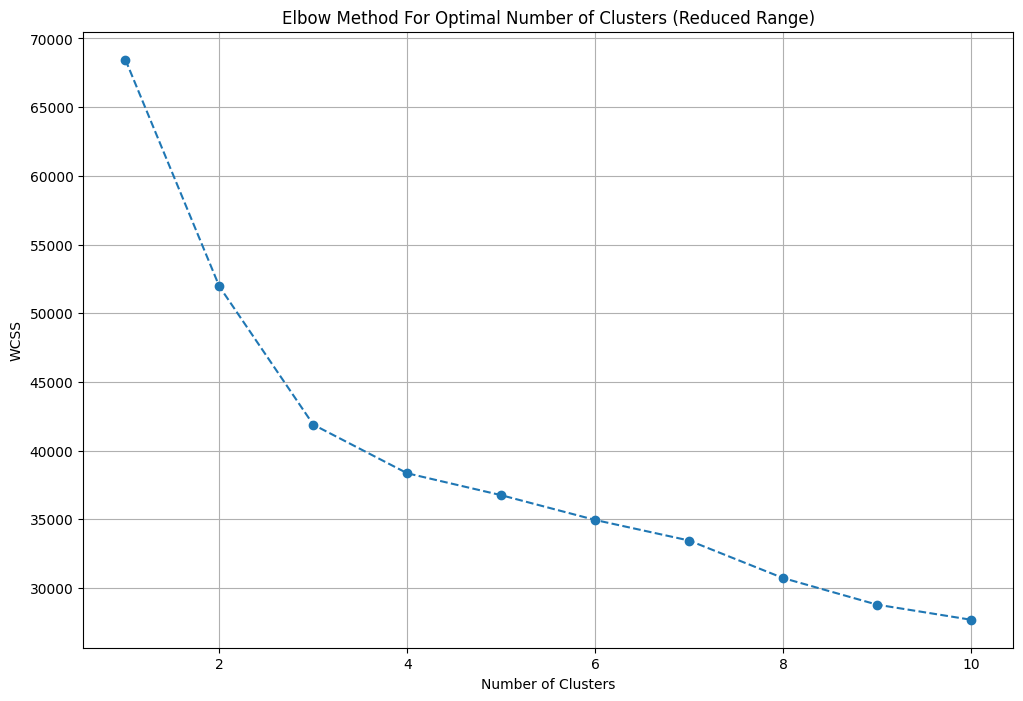

In [94]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [95]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [96]:
df_cl = df_cl.iloc[:,:-18]

In [97]:
df_cl['furnishing_type'] = cluster_assignments

In [98]:
df_cl.sample(5)[['furnishDetails','furnishing_type']]
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished

,furnishDetails,furnishing_type
1644,"['1 Wardrobe', '1 Fan', '1 Exhaust Fan', '1 Ge...",2
3159,NaN,1
2737,[],1
3010,"['1 Wardrobe', '1 Fan', '1 Light', 'No AC', 'N...",1
1554,"['2 Wardrobe', '4 Fan', '2 Geyser', '5 Light',...",1


## 5. Features

In [99]:
df_cl[['society','features']].sample(5)

,society,features
638,tulip petals,NaN
1074,tulip violet,"['Power Back-up', 'Feng Shui / Vaastu Complian..."
139,vatika signature villas,"['Feng Shui / Vaastu Compliant', 'Maintenance ..."
2221,independent,NaN
3753,sare homes,"['Security / Fire Alarm', 'Feng Shui / Vaastu ..."


In [101]:
int(df_cl['features'].isnull().sum())

635

In [116]:
from pathlib import Path

# Get the current notebook's directory
CURRENT_NOTEBOOK_DIR = Path().resolve()

# Assume project root is one level up from notebooks/
BASE_DIR = CURRENT_NOTEBOOK_DIR.parent.parent

# Define path to the data file
RAW_DATA_PATH2 = BASE_DIR / "Data_Gathering" / "City_Data" / "Gurgaon"

# # Load the data
# import pandas as pd
# df = pd.read_csv(RAW_DATA_PATH)

In [117]:
import pandas as pd
app_df = pd.read_csv(RAW_DATA_PATH2/'Apartment.csv')
app_df.head(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Pa...","{'Bajghera Road': '800 Meter', 'Palam Vihar Ha...",https://www.99acres.com/smartworld-one-dxp-sec...,"{'2 BHK': {'building_type': 'Apartment', 'area...","['Swimming Pool', 'Salon', 'Restaurant', 'Spa'..."
1,M3M Crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap Un...","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The N...",https://www.99acres.com/m3m-crown-sector-111-g...,"{'3 BHK': {'building_type': 'Apartment', 'area...","['Bowling Alley', 'Mini Theatre', 'Manicured G..."


In [118]:
app_df['PropertyName'] = app_df['PropertyName'].str.lower()

In [122]:
temp_df = df_cl[df_cl['features'].isnull()]

In [124]:
temp_df.shape

(635, 26)

In [125]:
x = temp_df.merge(app_df,left_on='society',right_on='PropertyName',how='left')['TopFacilities']

In [126]:
df_cl.loc[temp_df.index,'features'] = x.values

In [129]:
int(df_cl['features'].isnull().sum())

481

In [130]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [133]:
# Convert the string representation of lists in the 'features' column to actual lists
df_cl['features_list'] = df_cl['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df_cl['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [134]:
features_binary_df.sample(5)

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Air Hockey,Airy Rooms,Amphitheatre,Automated Car Wash,Badminton Court,...,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
1960,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,1,1,0,0
738,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0
1092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
2557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3389,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,1,1,0,0


In [135]:
features_binary_df.shape

(3803, 130)

In [136]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_binary_df)
    wcss_reduced.append(kmeans.inertia_)

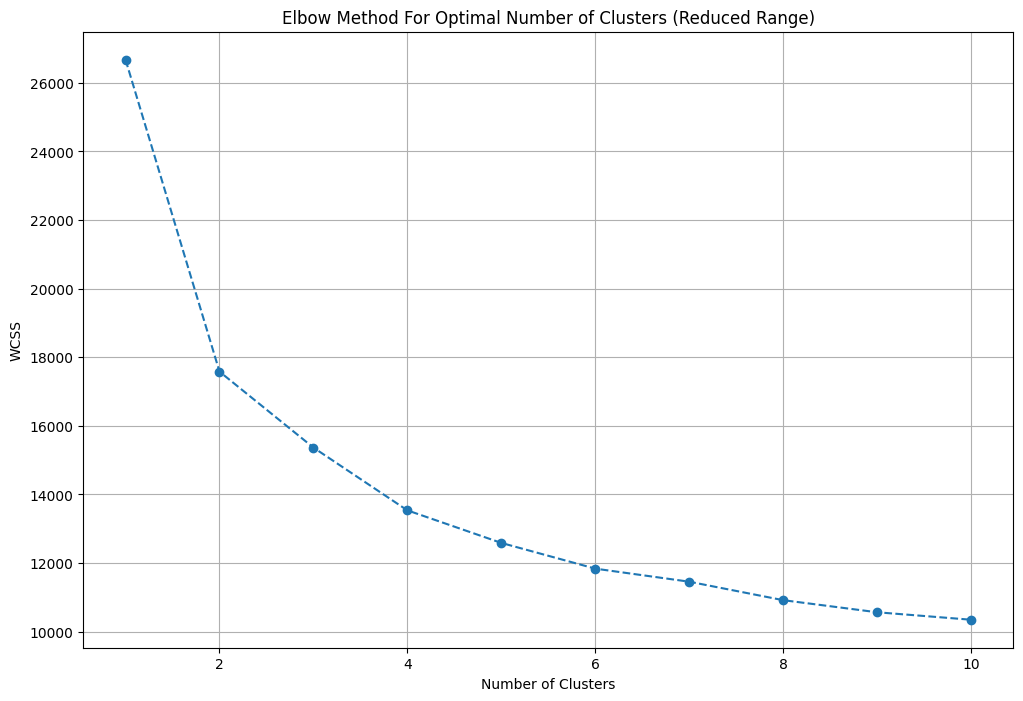

In [137]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [138]:
# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}
# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)

In [140]:
df_cl['luxury_score'] = luxury_score

In [142]:
df_cl.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,...,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,features_list,luxury_score
0,flat,signature global park 4,sector 36,0.82,7585.0,1081.0,Super Built up area 1081(100.43 sq.m.)Carpet a...,3,2,2,...,NaN,650.0,0,0,0,0,0,1,"[Lift(s), Park]",8
1,flat,smart world gems,sector 89,0.95,8600.0,1105.0,Carpet area: 1103 (102.47 sq.m.),2,2,2,...,NaN,1103.0,1,1,0,0,0,1,"[Power Back-up, Intercom Facility, Lift(s), Sw...",38
2,flat,pyramid elite,sector 86,0.46,79.0,58228.0,Carpet area: 58141 (5401.48 sq.m.),2,2,1,...,NaN,58141.0,0,0,0,0,0,1,"[Intercom Facility, Lift(s), Park]",15
3,flat,breez global hill view,sohna road,0.32,5470.0,585.0,Built Up area: 1000 (92.9 sq.m.)Carpet area: 5...,2,2,1,...,1000.0,585.0,0,0,0,0,0,1,"[Feng Shui / Vaastu Compliant, Security / Fire...",49
4,flat,bestech park view sanskruti,sector 92,1.60,8020.0,1995.0,Super Built up area 1995(185.34 sq.m.)Built Up...,3,4,3+,...,1615.0,1476.0,0,1,0,0,1,2,"[Centrally Air Conditioned, Water purifier, Se...",174


In [143]:
# cols to drop -> nearbyLocations,furnishDetails, features,features_list, additionalRoom
df_cl.drop(columns=['nearbyLocations','furnishDetails','features','features_list','additionalRoom'],inplace=True)

In [145]:
df_cl.sample(5)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,...,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
3315,flat,conscient heritage max,sector 102,1.75,9011.0,1942.0,Super Built up area 1942(180.42 sq.m.),3,4,3+,...,1942.0,NaN,NaN,0,1,0,0,0,2,94
592,flat,bestech park view ananda,sector 81,0.95,10626.0,894.0,Super Built up area 1360(126.35 sq.m.)Carpet a...,2,2,2,...,1360.0,NaN,894.0,0,0,0,0,0,2,104
2860,flat,breeze global heights,sector 33,0.40,6421.0,623.0,Built Up area: 623 (57.88 sq.m.)Carpet area: 5...,2,2,2,...,NaN,623.0,599.0,0,0,0,0,0,1,0
2692,house,independent,sector 50,13.20,27155.0,4861.0,Built Up area: 4861 (451.6 sq.m.),6,6,0,...,NaN,4861.0,NaN,0,0,0,0,0,1,0
618,flat,dlf the arbour,sector 63,7.52,19000.0,3958.0,Built Up area: 3956 (367.52 sq.m.)Carpet area:...,4,4,3,...,NaN,3956.0,2200.0,0,0,0,0,0,1,61


In [147]:
df_cl.shape

(3803, 23)

In [151]:
from pathlib import Path

# Get the current notebook's directory
CURRENT_NOTEBOOK_DIR = Path().resolve()

# Assume project root is one level up from notebooks/
BASE_DIR = CURRENT_NOTEBOOK_DIR.parent.parent

# Define path to the data file
RAW_DATA_PATH2 = BASE_DIR / "Data_Gathering" / "City_Data" / "Gurgaon" / "Feature_Engineering"

# # Load the data
# import pandas as pd
# df = pd.read_csv(RAW_DATA_PATH)

In [153]:
df_cl.to_csv(RAW_DATA_PATH2/'gurgaon_properties_after_featureEng.csv',index=False)